In [24]:
from importlib import reload

import modeltuning_LUNA; reload(modeltuning_LUNA)
from modeltuning_LUNA import *

import utils_LUNA; reload(utils_LUNA)
from utils_LUNA import *

In [2]:
luna_path = "../input/LUNA16/"
luna_subset_path = "../input/LUNA16/subset0/"
output_path = "../input/LUNA16/output/"
model_path = "../input/LUNA16/models/"
working_path = output_path
if not os.path.exists(model_path): os.makedirs(model_path)

### Loading and preprocessing train data

In [3]:
imgs_train = np.load(working_path+"trainImages.npy").astype(np.float32)
imgs_mask_train = np.load(working_path+"trainMasks.npy").astype(np.float32)

In [4]:
imgs_test = np.load(working_path+"testImages.npy").astype(np.float32)
imgs_mask_test_true = np.load(working_path+"testMasks.npy").astype(np.float32)

In [5]:
imgs_train.shape, imgs_mask_train.shape, imgs_test.shape, imgs_mask_test_true.shape

((268, 512, 512, 1), (268, 512, 512, 1), (66, 512, 512, 1), (66, 512, 512, 1))

image 6


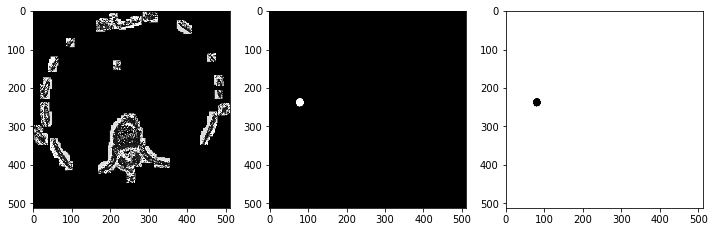

In [6]:
i = 6
print("image %d" % i)
fig,ax = plt.subplots(1,3,figsize=[12,12])
ax[0].imshow(np.squeeze(imgs_train[i]),cmap='gray')
ax[1].imshow(np.squeeze(imgs_mask_train[i]),cmap='gray')
ax[2].imshow(np.squeeze(imgs_train[i])*np.squeeze(imgs_mask_train[i]),cmap='gray')
plt.show()

In [7]:
mean = np.mean(imgs_train)  # mean for data centering
std = np.std(imgs_train)  # std for data normalization

imgs_train -= mean  # images should already be standardized, but just in case
imgs_train /= std

### Creating and compiling model

In [18]:
model = get_unet()

In [19]:
# Saving weights to unet.hdf5 at checkpoints
model_checkpoint = ModelCheckpoint(model_path+'unet.hdf5', monitor='loss', save_best_only=True)

### Fitting model

In [20]:
model.fit(imgs_train, imgs_mask_train, batch_size=2, epochs=20, verbose=2, shuffle=True,
              callbacks=[model_checkpoint])

Epoch 1/20
 - 80s - loss: -3.5042e-05 - dice_coef: 3.5042e-05
Epoch 2/20
 - 79s - loss: -3.6183e-05 - dice_coef: 3.6183e-05
Epoch 3/20
 - 79s - loss: -4.0231e-05 - dice_coef: 4.0231e-05
Epoch 4/20
 - 78s - loss: -1.1196e-01 - dice_coef: 0.1120
Epoch 5/20
 - 77s - loss: -1.7365e-01 - dice_coef: 0.1736
Epoch 6/20
 - 77s - loss: -1.7769e-01 - dice_coef: 0.1777
Epoch 7/20
 - 77s - loss: -1.7177e-01 - dice_coef: 0.1718
Epoch 8/20
 - 77s - loss: -1.7051e-01 - dice_coef: 0.1705
Epoch 9/20
 - 77s - loss: -1.8147e-01 - dice_coef: 0.1815
Epoch 10/20
 - 77s - loss: -1.6623e-01 - dice_coef: 0.1662
Epoch 11/20
 - 77s - loss: -1.6946e-01 - dice_coef: 0.1695
Epoch 12/20
 - 77s - loss: -1.7909e-01 - dice_coef: 0.1791
Epoch 13/20
 - 77s - loss: -1.7633e-01 - dice_coef: 0.1763
Epoch 14/20
 - 77s - loss: -1.6634e-01 - dice_coef: 0.1663
Epoch 15/20
 - 77s - loss: -1.6955e-01 - dice_coef: 0.1696
Epoch 16/20
 - 77s - loss: -1.7231e-01 - dice_coef: 0.1723
Epoch 17/20
 - 77s - loss: -1.7169e-01 - dice_coef: 0

### Load best weights from training session

In [21]:
model.load_weights(model_path+'unet.hdf5')

### Predicting masks on test data

In [25]:
num_test = len(imgs_test)
imgs_mask_test = np.ndarray([num_test,512,512,1],dtype=np.float32) # Channels Last
#imgs_mask_test = np.ndarray([num_test,1,512,512],dtype=np.float32)
for i in range(num_test):
    imgs_mask_test[i] = model.predict([imgs_test[i:i+1]], verbose=0) #[0] # Channels Last

#np.save('masksTestPredicted.npy', imgs_mask_test)
save_array('masksTestPredicted1.bc', imgs_mask_test)

mean = 0.0
for i in range(num_test):
    mean+=dice_coef_np(np.squeeze(imgs_mask_test_true[i]), np.squeeze(imgs_mask_test[i]))
mean/=num_test
print("Mean Dice Coeff : ",mean)

Mean Dice Coeff :  0.367768130673324
